In [ ]:
import pprint
import operator
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [ ]:
class FuzzyKNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=3, plot=False):
        self.k = k
        self.plot = plot


    def fit(self, X, y=None):
        self._check_params(X,y)
        self.X = X
        self.y = y

        self.xdim = len(self.X[0])
        self.n = len(y)

        classes = list(set(y))
        classes.sort()
        self.classes = classes

        self.df = pd.DataFrame(self.X)
        self.df['y'] = self.y

        self.memberships = self._compute_memberships()

        self.df['membership'] = self.memberships

        self.fitted_ = True
        return self


    def predict(self, X):
        if self.fitted_ == None:
            raise Exception('predict() called before fit()')
        else:
            m = 2
            y_pred = []

            for x in X:
                neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x)

                votes = {}
                for c in self.classes:
                    den = 0
                    for n in range(self.k):
                        dist = np.linalg.norm(x - neighbors.iloc[n,0:self.xdim])
                        den += 1 / (dist ** (2 / (m-1)))

                    neighbors_votes = []
                    for n in range(self.k):
                        dist = np.linalg.norm(x - neighbors.iloc[n,0:self.xdim])
                        num = (neighbors.iloc[n].membership[c]) / (dist ** (2 / (m-1)))

                        vote = num/den
                        neighbors_votes.append(vote)
                    votes[c] = np.sum(neighbors_votes)

                pred = max(votes.items(), key=operator.itemgetter(1))[0]
                y_pred.append((pred, votes))

            return y_pred


    def score(self, X, y):
        if self.fitted_ == None:
            raise Exception('score() called before fit()')
        else:
            predictions = self.predict(X)
            y_pred = [t[0] for t in predictions]
            confidences = [t[1] for t in predictions]

            return accuracy_score(y_pred=y_pred, y_true=y)


    def _find_k_nearest_neighbors(self, df, x):
        X = df.iloc[:,0:self.xdim].values

        df['distances'] = [np.linalg.norm(X[i] - x) for i in range(self.n)]

        df.sort_values(by='distances', ascending=True, inplace=True)
        neighbors = df.iloc[0:self.k]

        return neighbors


    def _get_counts(self, neighbors):
        groups = neighbors.groupby('y')
        counts = {group[1]['y'].iloc[0]:group[1].count()[0] for group in groups}

        return counts


    def _compute_memberships(self):
        memberships = []
        for i in range(self.n):
            x = self.X[i]
            y = self.y[i]

            neighbors = self._find_k_nearest_neighbors(pd.DataFrame.copy(self.df), x)
            counts = self._get_counts(neighbors)

            membership = dict()
            for c in self.classes:
                try:
                    uci = 0.49 * (counts[c] / self.k)
                    if c == y:
                        uci += 0.51
                    membership[c] = uci
                except:
                    membership[c] = 0

            memberships.append(membership)
        return memberships


    def _check_params(self, X, y):
        if type(self.k) != int:
            raise Exception('"k" should have type int')
        elif self.k >= len(y):
            raise Exception('"k" should be less than no of feature sets')
        elif self.k % 2 == 0:
            raise Exception('"k" should be odd')

        if type(self.plot) != bool:
            raise Exception('"plot" should have type bool')

In [ ]:
# iris = load_iris()
# breast = load_breast_cancer()
# dataset = breast

import pandas as pd
import io
from google.colab import files
uploaded = files.upload()
pand = pd.read_csv(io.StringIO(uploaded['HTRU_2.csv'].decode('utf-8')))
dataset=pand.to_numpy()
X = dataset[:,:8]
y = dataset[:,8]

X_train, X_test, y_train, y_test = train_test_split(X,y)

Saving HTRU_2.csv to HTRU_2 (2).csv


In [ ]:
knn = KNeighborsClassifier()
fknn = FuzzyKNN()
svm=SVC(kernel='linear',C=1)
naive=GaussianNB()
mlp=MLPClassifier(hidden_layer_sizes=(300,100,50), activation="tanh", solver="sgd")

knn.fit(X_train, y_train)
fknn.fit(X_train, y_train)
svm.fit(X_train, y_train)
naive.fit(X_train, y_train)
mlp.fit(X_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(300, 100, 50),
              solver='sgd')

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test,knn.predict(X_test)).ravel()   #knn
knn_fpr=fp/(fp+tn)
knn_precision=tp/(tp+fp)
knn_recall=tp/(tp+fn)
knn_specificity=tn/(fp+tn)
knn_fscore=2*knn_precision*knn_recall/(knn_precision+knn_recall)
knn_gmean=math.sqrt(knn_recall*knn_specificity)

tn, fp, fn, tp = confusion_matrix(y_test,[i[0] for i in fknn.predict(X_test)]).ravel()
fknn_fpr=fp/(fp+tn)
fknn_precision=tp/(tp+fp)
fknn_recall=tp/(tp+fn)
fknn_specificity=tn/(fp+tn)
fknn_fscore=2*fknn_precision*fknn_recall/(fknn_precision+fknn_recall)
fknn_gmean=math.sqrt(fknn_recall*fknn_specificity)

tn, fp, fn, tp = confusion_matrix(y_test,svm.predict(X_test)).ravel() #SVM
svm_fpr=fp/(fp+tn)
svm_precision=tp/(tp+fp)
svm_recall=tp/(tp+fn)
svm_specificity=tn/(fp+tn)
svm_fscore=2*svm_precision*svm_recall/(svm_precision+svm_recall)
svm_gmean=math.sqrt(svm_recall*svm_specificity)


tn, fp, fn, tp = confusion_matrix(y_test,naive.predict(X_test)).ravel() #Naive Bayes
naive_fpr=fp/(fp+tn)
naive_precision=tp/(tp+fp)
naive_recall=tp/(tp+fn)
naive_specificity=tn/(fp+tn)
naive_fscore=2*naive_precision*naive_recall/(naive_precision+naive_recall)
naive_gmean=math.sqrt(naive_recall*naive_specificity)


tn, fp, fn, tp = confusion_matrix(y_test,mlp.predict(X_test)).ravel() #MLP
mlp_fpr=fp/(fp+tn)
mlp_precision=tp/(tp+fp)
mlp_recall=tp/(tp+fn)
mlp_specificity=tn/(fp+tn)
mlp_fscore=2*mlp_precision*mlp_recall/(mlp_precision+mlp_recall)
mlp_gmean=math.sqrt(mlp_recall*mlp_specificity)

titles=["Knn","FKnn","SVM","Naive Bayes","MLP"]




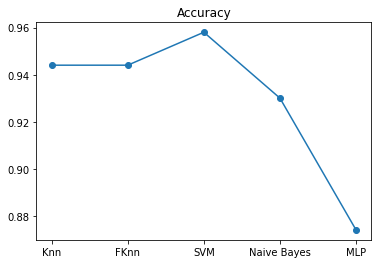

In [ ]:
titles.titles.reverse()

accuracy_list=[knn.score(X_test,y_test),fknn.score(X_test,y_test),svm.score(X_test,y_test),naive.score(X_test,y_test),mlp.score(X_test,y_test)].reverse()

plt.plot(titles,accuracy_list,'o-')
plt.title("Accuracy")
plt.show()

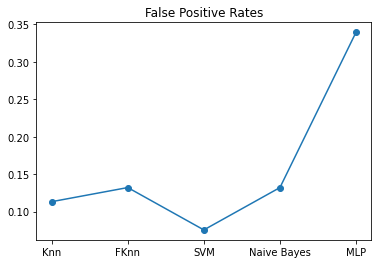

In [ ]:
fpr_list=[knn_fpr,fknn_fpr,svm_fpr,naive_fpr,mlp_fpr].reverse()

plt.plot(titles,fpr_list,'o-')
plt.title("False Positive Rates")
plt.show()

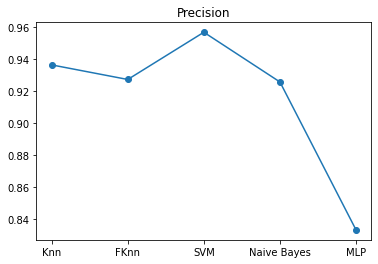

In [ ]:
precision_list=[knn_precision,fknn_precision,svm_precision,naive_precision,mlp_precision].reverse()

plt.plot(titles,precision_list,'o-')
plt.title("Precision")
plt.show()

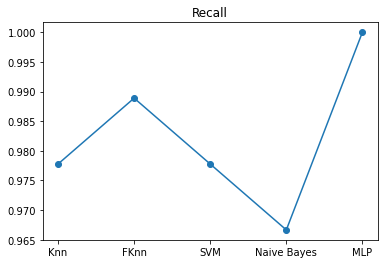

In [ ]:
recall_list=[knn_recall,fknn_recall,svm_recall,naive_recall,mlp_recall].reverse()

plt.plot(titles,recall_list,'o-')
plt.title("Recall")
plt.show()

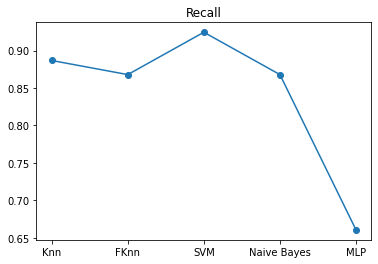

In [ ]:
specificity_list=[knn_specificity,fknn_specificity,svm_specificity,naive_specificity,mlp_specificity].reverse()

plt.plot(titles,specificity_list,'o-')
plt.title("Recall")
plt.show()

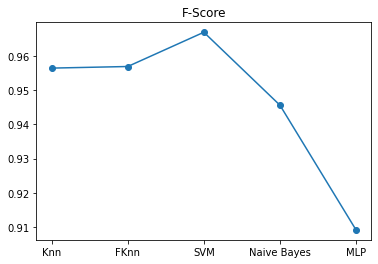

In [ ]:
fscore_list=[knn_fscore,fknn_fscore,svm_fscore,naive_fscore,mlp_fscore].reverse()

plt.plot(titles,fscore_list,'o-')
plt.title("F-Score")
plt.show()

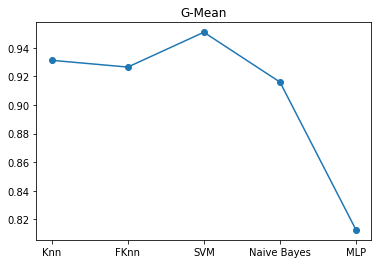

In [ ]:
gmean_list=[knn_gmean,fknn_gmean,svm_gmean,naive_gmean,mlp_gmean].reverse()

plt.plot(titles,gmean_list,'o-')
plt.title("G-Mean")
plt.show()